# EBI Metadata - Analysis of U.S. States

In [1]:
import pandas as pd

df = pd.read_csv('../../data/metadata_EBI_preprocessed.csv',
                 dtype={'collected_by': object,
                        'collection_date': object,
                        'culture_collection': object,
                        'identified_by': object,
                        'isolate': object,
                        'isolation_source': object,
                        'keywords': object,
                        'lab_host': object,
                        'location': object,
                        'sample_accession': object,
                        'strain': object,
                        'study_accession': object})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520583 entries, 0 to 2520582
Data columns (total 34 columns):
 #   Column                Dtype  
---  ------                -----  
 0   accession             object 
 1   base_count            int64  
 2   collected_by          object 
 3   collection_date       object 
 4   country_and_region    object 
 5   culture_collection    object 
 6   dataclass             object 
 7   description           object 
 8   environmental_sample  bool   
 9   first_public          object 
 10  germline              bool   
 11  host                  object 
 12  identified_by         object 
 13  isolate               object 
 14  isolation_source      object 
 15  keywords              object 
 16  lab_host              object 
 17  last_updated          object 
 18  location              object 
 19  mol_type              object 
 20  sample_accession      object 
 21  scientific_name       object 
 22  sequence_md5          object 
 23  sequenc

## Extraction of U.S. States

The cells under here belonging to the extraction of the U.S. states have to be executed before executing the cells belonging to further analyses below this extraction.

In [8]:
df_usa = df[df['country'] == 'USA']

In [3]:
# Filter for non-NaN regions
original_len_usa = len(df_usa)
df_usa = df_usa[df_usa['region'].notna()]
print(f'{original_len_usa - len(df_usa)} USA samples removed, now there are {len(df_usa)} samples.')

146392 USA samples removed, now there are 1110923 samples.


In [4]:
df_usa['region'].value_counts()

California         133086
Florida             81698
Minnesota           73512
Massachusetts       62987
Texas               59338
                    ...  
SC, McBee               1
PA, Landenberg          1
NJ, Clemson             1
NC, Advance             1
Kansas, Johnson         1
Name: region, Length: 1504, dtype: int64

In [5]:
df_usa['region'].nunique()  # 1504 regions -> includes more than just U.S. states

1504

In [33]:
import json

with open('../helper_dicts/usa_states.json') as f:
    usa_states = json.load(f)

# Note: "District of Columbia (Washington, D.C.)" does not belong to any state and therefore is listed additionally to 50 existing states
# See https://www.history.com/news/washington-dc-statehood-reconstruction
len(usa_states)

51

In [ ]:
import numpy as np

# Manually fix typos or too specific descriptions in "regions"
df_usa['region'].replace(['Californi', 'District of Columbia', 'Masschusetts, Essex county', 'Ilinois, Chicago', 'NewYork', 'Middlesex county'],
                         ['California', 'District Of Columbia', 'Massachusetts', 'Illinois', 'New York', 'New Jersey'], inplace=True)

def get_usa_states(region):
    # Get region by abbreviation
    if region.upper() in usa_states:
        return usa_states[region.upper()]
    # Get region by long version
    elif region.title() in list(usa_states.values()):
        return region.title()
    # Get region in front of comma
    elif region.split(',')[0].upper() in usa_states:
        return usa_states[region.split(',')[0].upper()]
    elif region.split(',')[0].title() in list(usa_states.values()):
        return region.split(',')[0].title()
    elif len(region.split(',')) >= 2:
        # Get region after first comma
        if region.split(',')[1].upper() in usa_states:
            return usa_states[region.split(',')[1].upper()]
        elif region.split(',')[1].title() in list(usa_states.values()):
            return region.split(',')[1].title()
        # Get region after first comma and whitespace
        elif region.split(',')[1][1:].upper() in usa_states:
            return usa_states[region.split(',')[1][1:].upper()]
        elif region.split(',')[1][1:].title() in list(usa_states.values()):
            return region.split(',')[1][1:].title()
    # Get region in front of slash and whitespace (catch special case "Louisiana / New Orleans")
    elif region.split('/')[0][:-1].title() in list(usa_states.values()):
        return region.split('/')[0][:-1].title()
    # Get region after whitespace (catch special case "SLIDELL LA")
    elif len(region.split(' ')) >= 2 and region.split(' ')[1].upper() in usa_states:
        return usa_states[region.split(' ')[1].upper()]
    else:
        return np.nan

# Add column with U.S. states in long version
df_usa['usa_state'] = df_usa.apply(lambda row: get_usa_states(str(row['region'])), axis=1)

In [35]:
# Check how many regions still contain more/less than state
unset_states = df_usa[df_usa['usa_state'].isna()]
unset_states['region'].value_counts() # -> 13 unique regions not assignable to state (islands, unknown, not existing abbreviations etc - as expected)

Puerto Rico                   1294
PR                             419
GU                             334
MP                             142
VI                              40
Unknown                         32
Guam                            15
NG                              14
Virgin Islands                   3
Virgin Islands of the U.S.       3
UNKNOWN                          3
CB                               1
NA, Santa Isabel                 1
Name: region, dtype: int64

In [40]:
display(df_usa['usa_state'].value_counts())

California              162136
Florida                 101068
Minnesota                74022
Texas                    65383
Massachusetts            63346
Washington               35892
North Carolina           35492
Georgia                  35039
Pennsylvania             33939
Colorado                 33524
Arizona                  29334
New Jersey               28532
Michigan                 27324
New York                 26364
Illinois                 25399
Tennessee                22262
Virginia                 21983
Ohio                     19841
Maryland                 18583
West Virginia            16749
Wisconsin                16491
Indiana                  15930
Utah                     15399
New Mexico               13578
South Carolina           13464
Nevada                   12288
Missouri                 11941
Alabama                  11229
Oregon                    9964
Arkansas                  9091
Kentucky                  8866
Vermont                   8746
Rhode Is

In [39]:
df_usa.to_csv('../../data/metadata_EBI_usa_states.csv', index=False)

## Sample Count per State

In [ ]:
import pandas as pd

df_usa = pd.read_csv('../../data/metadata_EBI_usa_states.csv')

In [118]:
# Install GDAL wheel file (https://www.lfd.uci.edu/~gohlke/pythonlibs/#gdal) and Fiona wheel file (https://www.lfd.uci.edu/~gohlke/pythonlibs/#fiona) before installing geopandas
# Recommended: GDAL-3.3.3-cp37-cp37m-win_amd64.whl and Fiona-1.8.20-cp37-cp37m-win_amd64.whl
# Map plots needed from now on to show which states are near to each other
import geopandas as gpd

In [137]:
# Shapefile taken from https://alicia.data.socrata.com/Government/States-21basic/jhnu-yfrj
# .dbf, .prj and .
# shx file have to be in same folder
usa_geo = gpd.read_file('../../data/geo_usa_states.shp')
usa_geo.head()

,drawseq,state_abbr,state_fips,state_name,sub_region,geometry
0,NaN,HI,15,Hawaii,Pacific,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,NaN,WA,53,Washington,Pacific,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,NaN,MT,30,Montana,Mountain,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."
3,NaN,ME,23,Maine,New England,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,NaN,ND,38,North Dakota,West North Central,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."


<AxesSubplot:>

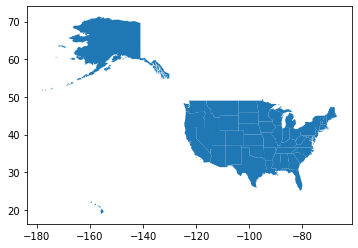

In [10]:
usa_geo.plot()

<AxesSubplot:>

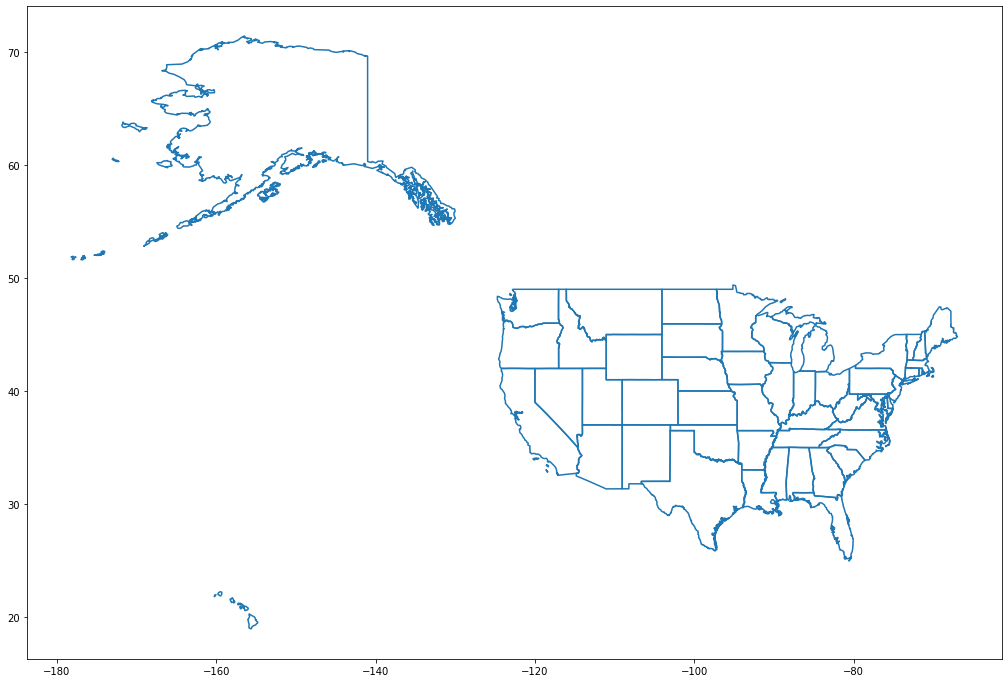

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(28, 12))

# Only plot boundaries
usa_geo.boundary.plot(ax=ax)

# Only plot boundaries and remove Hawaii (index 0, bottom left) and Alaska (index 51, upper left)
# usa_geo[1:50].boundary.plot(ax=ax)
# usa_geo[~usa_geo['state_name'].isin(['Alaska', 'Hawaii'])].boundary.plot(ax=ax)

In [149]:
# Add number of samples per state as new column
state_counts = df_usa['usa_state'].value_counts().sort_index().to_dict()
usa_geo['state_count'] = usa_geo['state_name'].map(state_counts)

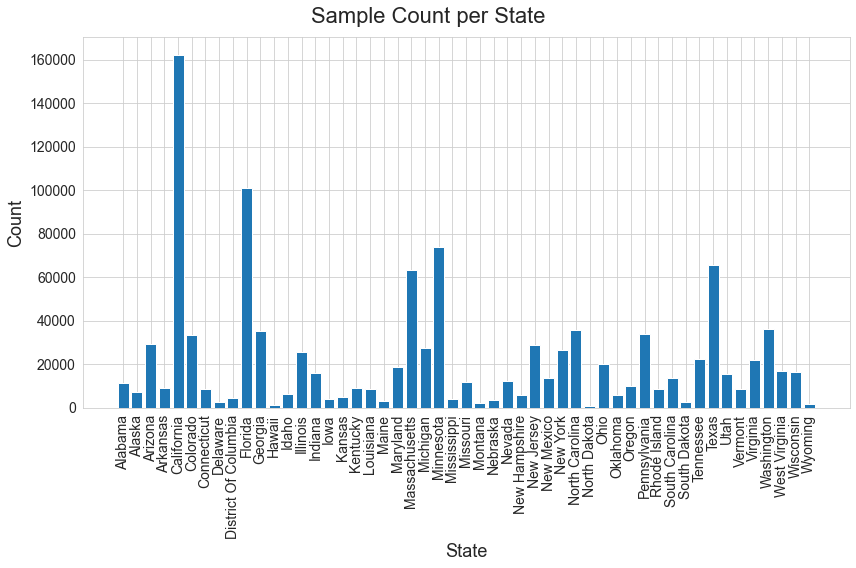

In [116]:
import seaborn as sns

sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(12, 8))
plt.bar(list(state_counts.keys()), list(state_counts.values()))

fig.suptitle('Sample Count per State', fontsize=22)
plt.xlabel('State', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../../plots/state_counts_barchart.png', dpi=300)
plt.close()

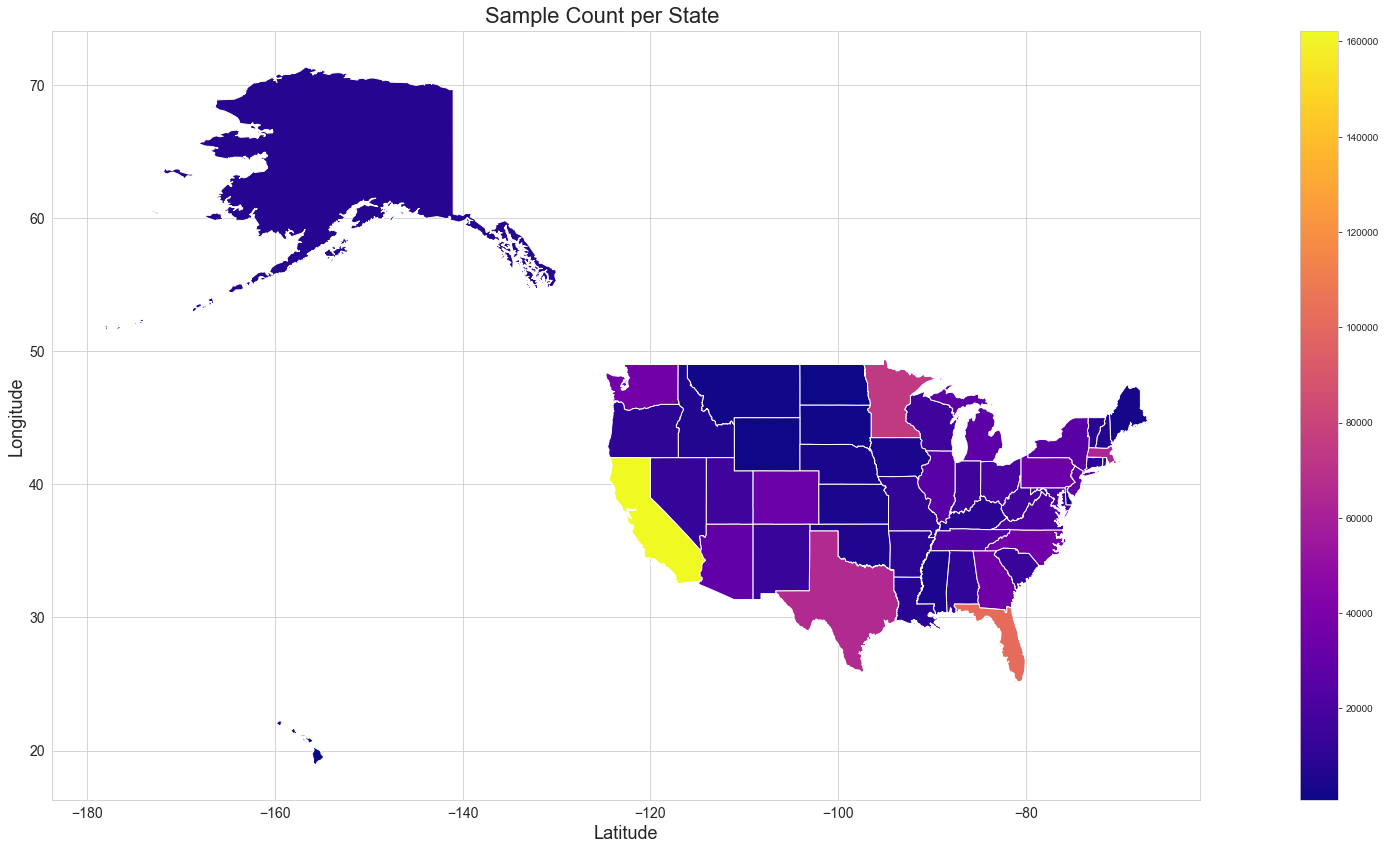

In [73]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(28, 12))
usa_geo.plot(column='state_count', ax=ax, legend=True, cmap='plasma')

fig.suptitle('Sample Count per State', fontsize=22)
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../../plots/state_counts_map.png', dpi=300)
plt.close()

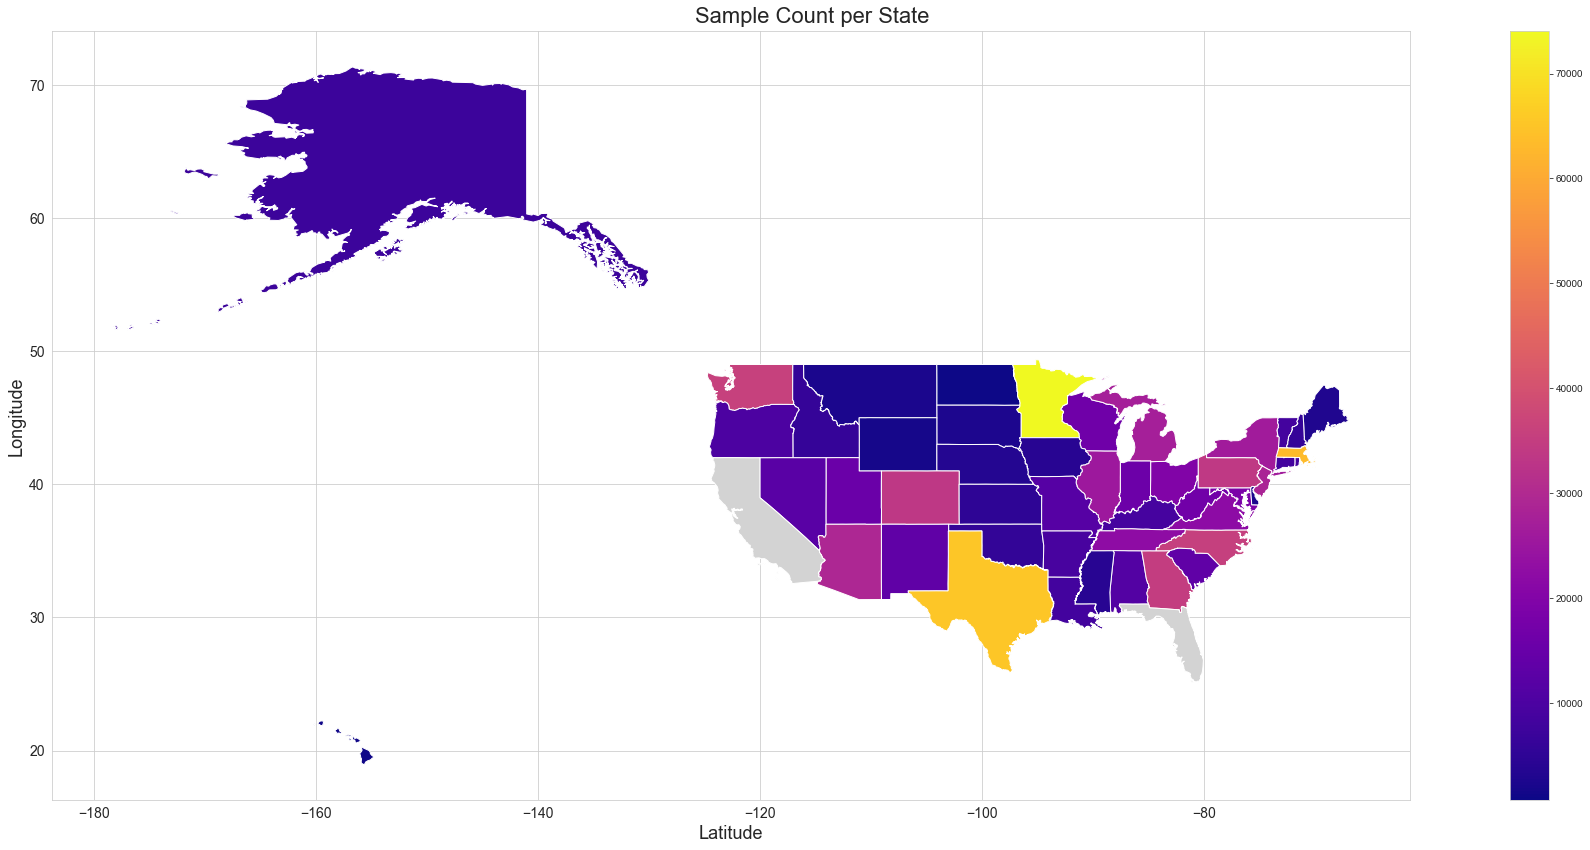

In [72]:
# Remove most represented states
plotdata = usa_geo[~usa_geo['state_name'].isin(['California', 'Florida'])]

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(28, 12))
plotdata.plot(column='state_count', ax=ax, legend=True, cmap='plasma')

# Add removed states as grey fields
usa_geo[usa_geo['state_name'].isin(['California', 'Florida'])].plot(color='lightgrey', ax=ax)

fig.suptitle('Sample Count per State', fontsize=22)
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../../plots/state_counts_map_reduced.png', dpi=300)
plt.close()

## Sample Count per State - Scaled by Number of Inhabitants

In [120]:
import json

with open('../helper_dicts/usa_states_inhabitants.json') as f:
    state_inhabitants = json.load(f)

usa_geo['n_inhabitants'] = usa_geo['state_name'].map(state_inhabitants)

In [61]:
usa_geo['count_inhabitant_ratio'] = usa_geo['state_count'] / usa_geo['n_inhabitants']

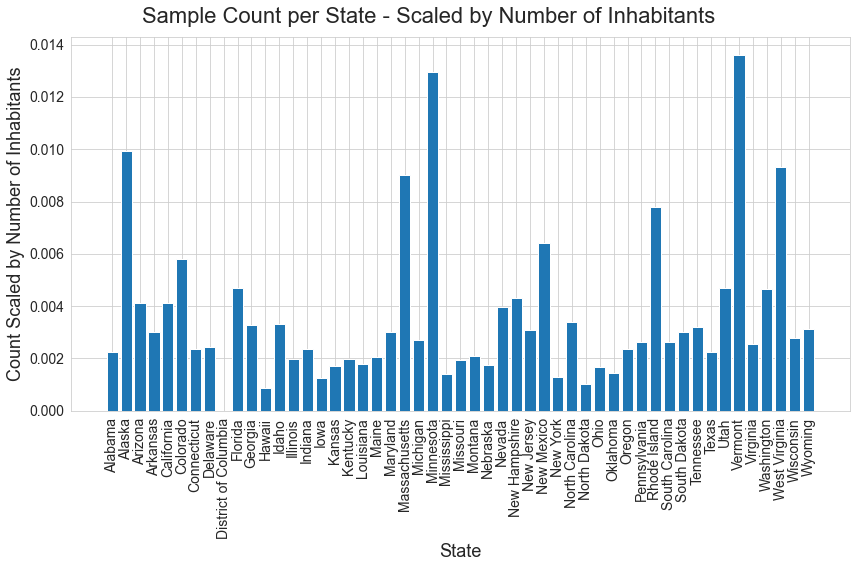

In [117]:
sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(12, 8))
usa_geo = usa_geo.sort_values(by=['state_name'])
plt.bar(usa_geo['state_name'].tolist(), usa_geo['count_inhabitant_ratio'].tolist())

fig.suptitle('Sample Count per State - Scaled by Number of Inhabitants', fontsize=22)
plt.xlabel('State', fontsize=18)
plt.ylabel('Count Scaled by Number of Inhabitants', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../../plots/state_counts_by_inhabitants_barchart.png', dpi=300)
plt.close()

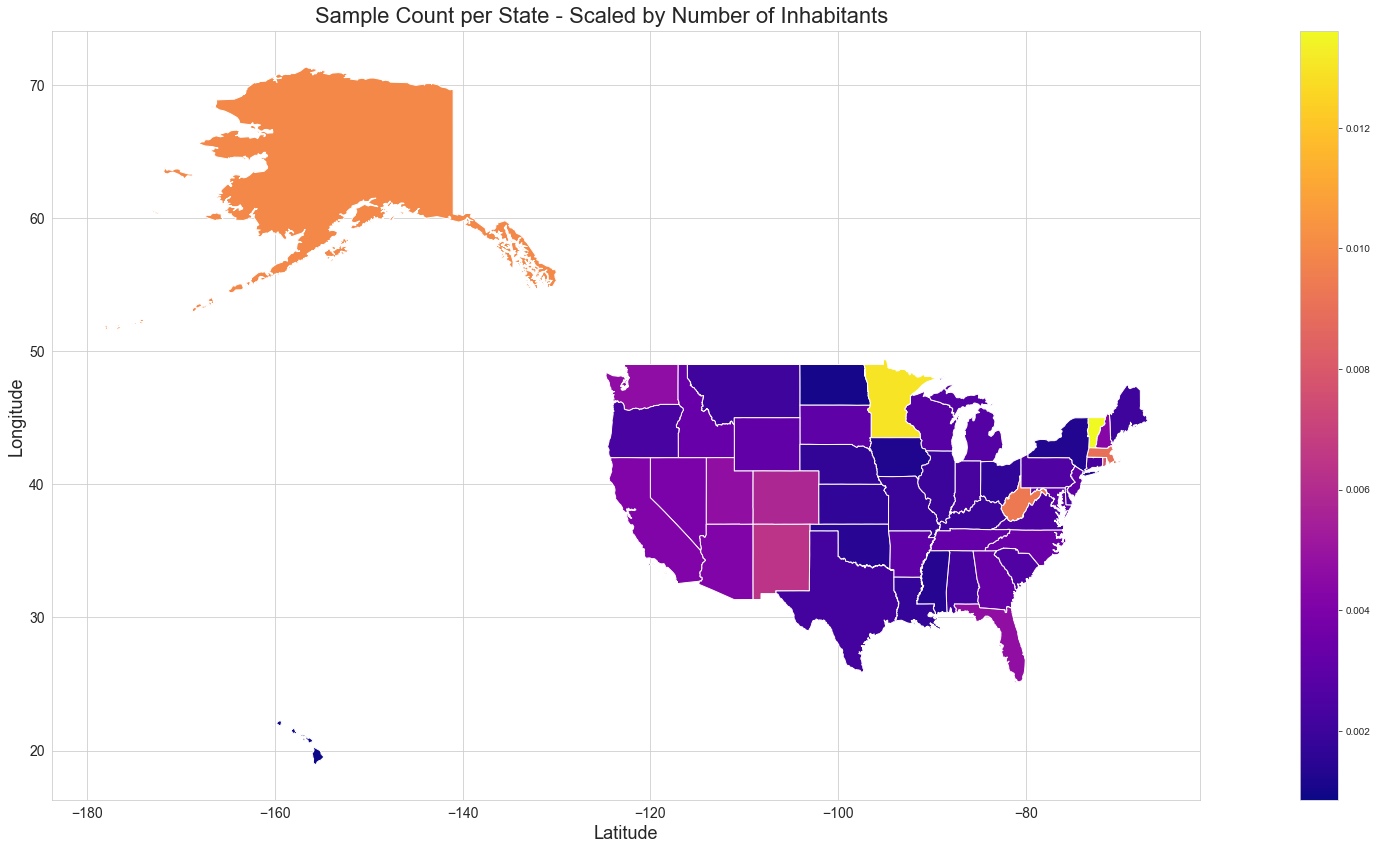

In [75]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(28, 12))
usa_geo.plot(column='count_inhabitant_ratio', ax=ax, legend=True, cmap='plasma')

fig.suptitle('Sample Count per State - Scaled by Number of Inhabitants', fontsize=22)
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../../plots/state_counts_by_inhabitants_map.png', dpi=300)
plt.close()

## Sample Count per State - Scaled by Number of Infections

In [155]:
# Taken from https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports_us/01-07-2022.csv
# Documentation at https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data#field-description-1
usa_states_hopkins = pd.read_csv('../../data/JHU_usa_states.csv')
usa_states_hopkins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Province_State        58 non-null     object 
 1   Country_Region        58 non-null     object 
 2   Last_Update           58 non-null     object 
 3   Lat                   56 non-null     float64
 4   Long_                 56 non-null     float64
 5   Confirmed             58 non-null     int64  
 6   Deaths                58 non-null     int64  
 7   Recovered             0 non-null      float64
 8   Active                0 non-null      float64
 9   FIPS                  58 non-null     float64
 10  Incident_Rate         56 non-null     float64
 11  Total_Test_Results    56 non-null     float64
 12  People_Hospitalized   0 non-null      float64
 13  Case_Fatality_Ratio   58 non-null     float64
 14  UID                   58 non-null     float64
 15  ISO3                  58 

In [153]:
import json

with open('../helper_dicts/usa_states.json') as f:
    usa_states = json.load(f)

states_hopkins = usa_states_hopkins['Province_State'].tolist()
states_relevant = list(usa_states.values())

# Check if right U.S. states are not listed in relevant states
list(set(states_hopkins) - set(states_relevant))

['Puerto Rico',
 'American Samoa',
 'Grand Princess',
 'Virgin Islands',
 'Guam',
 'District of Columbia',
 'Northern Mariana Islands',
 'Diamond Princess']

In [ ]:
def get_n_infections(state):
    return usa_states_hopkins[usa_states_hopkins['Province_State'] == state]['Confirmed'].iloc[0]

usa_geo['n_infections'] = usa_geo.apply(lambda row: get_n_infections(row['state_name']), axis=1)
usa_geo['count_infection_ratio'] = usa_geo['state_count'] / usa_geo['n_infections']

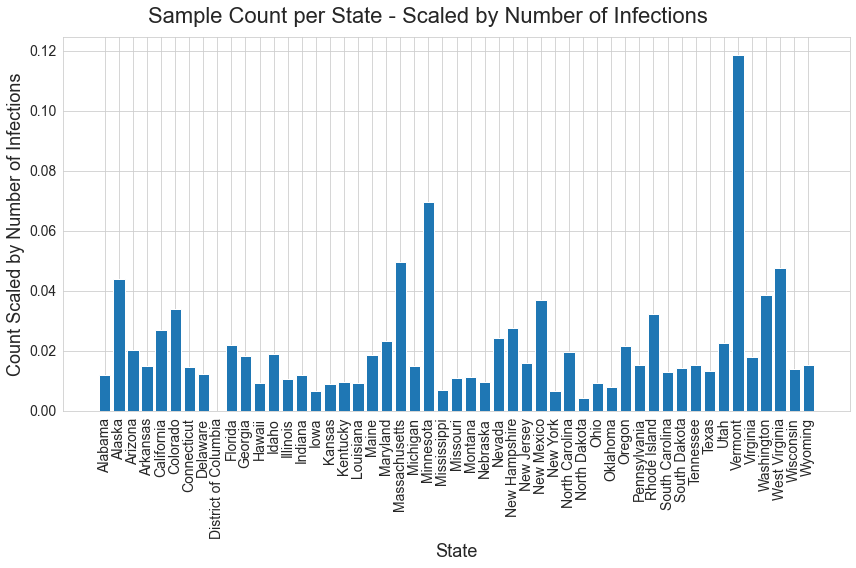

In [156]:
# Plot amount of samples per state in relation to #infections as bar chart
sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(12, 8))
usa_geo = usa_geo.sort_values(by=['state_name'])
plt.bar(usa_geo['state_name'].tolist(), usa_geo['count_infection_ratio'].tolist())

fig.suptitle('Sample Count per State - Scaled by Number of Infections', fontsize=22)
plt.xlabel('State', fontsize=18)
plt.ylabel('Count Scaled by Number of Infections', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../../plots/state_counts_by_infections_barchart.png', dpi=300)
plt.close()

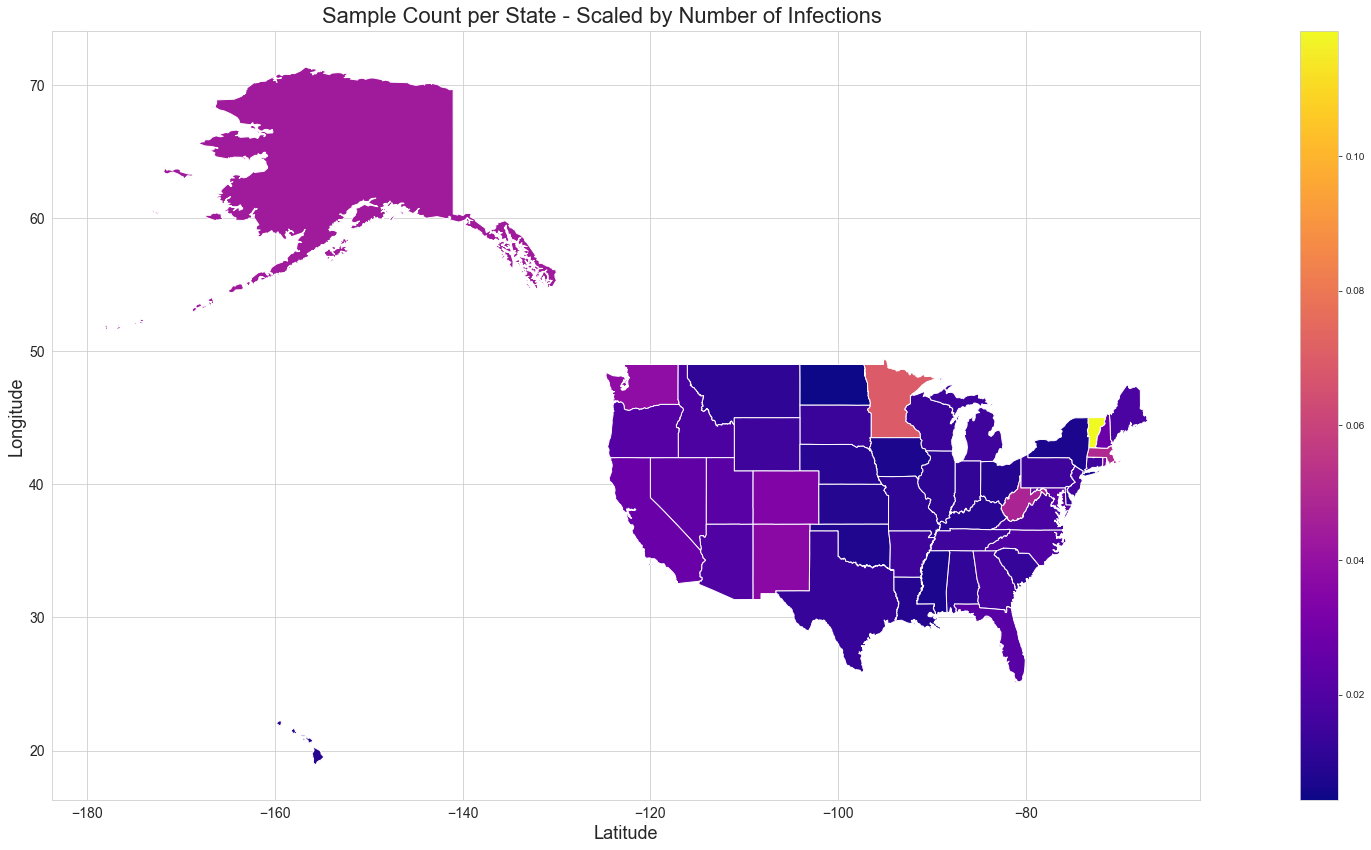

In [154]:
# Plot amount of samples per state in relation to #infections on map
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(28, 12))
usa_geo.plot(column='count_infection_ratio', ax=ax, legend=True, cmap='plasma')

fig.suptitle('Sample Count per State - Scaled by Number of Infections', fontsize=22)
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../../plots/state_counts_by_infections_map.png', dpi=300)
plt.close()